# Анализ расходов отдела маркетинга

## Цель проекта:

В наличии маркетинговые данные развлекательного приложения:
* лог сервера с данными о посещениях приложения новыми пользователями;
* выгрузка их покупок за этот период;
* статистика рекламных расходов.

Несколько месяцев бизнес несет убытки, хотя в привлечение пользователей вкладывается большие суммы средств. Необходимо выяснить причину и дать рекомендации отделу маркетинга. В организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

**Описание данных:**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузка данных, подготовка данных к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# создадим переменные и выгрузим в них данные из файлов
try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except:
    print('ошибка выгрузки')    
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [3]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [4]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Наименования колонок во всех таблицах указаны некорректно, приведем все названия в "змеиный регистр".

In [5]:
def snake_register (dataframe):
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]
    return dataframe

visits = snake_register(visits)
orders = snake_register(orders)
costs = snake_register(costs)

In [6]:
visits.head(1)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


In [7]:
orders.head(1)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99


In [8]:
costs.head(1)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3


In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [12]:
# приведем столбцы с датами к типу datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [14]:
# проверим таблицы на наличие в них явных дубликатов
print(f'Количество дубликатов в таблице visits:', visits.duplicated().sum())
print(f'Количество дубликатов в таблице orders:', orders.duplicated().sum())
print(f'Количество дубликатов в таблице costs:', costs.duplicated().sum())

Количество дубликатов в таблице visits: 0
Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице costs: 0


По итогам первичной предобработки таблиц:
дубликаты и пропуски данных не обнаружены, столбцы с датами приведены к типу datetime, наименования столбцов приведены к необходимому формату.

## Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии

### get_profiles

In [16]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):
    
    # Шаг 1. находим параметры первых посещений
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # добавим признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg(
        {'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

### get_retention

In [17]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### get_conversion

In [18]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### get_ltv

In [19]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### filter_data

In [20]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### plot_retention

In [21]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### plot_conversion

In [22]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### plot_ltv_roi

In [23]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [24]:
# создадим таблицу с профилями пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [25]:
print('Минимальная дата привлечения посетителей:', profiles['first_ts'].min())
print('Максимальная дата привлечения посетителей:', profiles['first_ts'].max())

Минимальная дата привлечения посетителей: 2019-05-01 00:00:41
Максимальная дата привлечения посетителей: 2019-10-27 23:59:04


### Страны

In [26]:
# определим из каких стран к нам приходят посетители и долю платящих пользователей
profiles_grouped = (
    profiles.groupby(['region'])
    .agg({'user_id': 'count', 'payer': 'mean'})
    .sort_values('user_id', ascending=False)
    .style.format({'payer': '{:.2%}'})
)
profiles_grouped

,user_id,payer
region,,
United States,100002,6.90%
UK,17575,3.98%
France,17450,3.80%
Germany,14981,4.11%


In [27]:
# доля стран в общем количестве привлеченных пользователей
profiles['region'].value_counts(normalize=True) * 100

United States    66.664445
UK               11.716042
France           11.632713
Germany           9.986801
Name: region, dtype: float64

Наибольше количество пользователей приходится на США, доля платящих среди них, также больше, относительно других стран - 6.9%

### Устройства

In [28]:
# определим какими устройствами пользуются клиенты и их количество
profiles['device'].value_counts()

iPhone     54479
Android    35032
PC         30455
Mac        30042
Name: device, dtype: int64

In [29]:
# доля устройств в общем количестве устройств
profiles['device'].value_counts(normalize=True) * 100

iPhone     36.317396
Android    23.353421
PC         20.302251
Mac        20.026932
Name: device, dtype: float64

In [30]:
# определим дополнительно сумму платящих и их долю по устройствам
profiles.groupby(['device']).agg({'user_id': 'count', 'payer': 'mean'}).sort_values('user_id', ascending=False).style.format({'payer' : '{:.2%}'})

,user_id,payer
device,,
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%
Mac,30042,6.36%


Наибольшее количество пользователей используют iPhone - 54479 пользователей (суммарная доля 36.3%). Доля остальных устройств (Android, PC и Mac) примерно одинаковая: 23-20%.

### Каналы привлечения

In [32]:
# определим по каким каналам приходят клиенты, а также долю платящих пользователей в канале
profiles_by_channel = (
    profiles.groupby(['channel'])
    .agg({'user_id' : 'count', 'payer' : 'mean'})
    .sort_values('user_id', ascending=False)
    .style.format({'payer': '{:.2%}'})
)
profiles_by_channel

,user_id,payer
channel,,
organic,56439,2.06%
FaceBoom,29144,12.20%
TipTop,19561,9.60%
OppleCreativeMedia,8605,2.71%
LeapBob,8553,3.06%
WahooNetBanner,8553,5.30%
RocketSuperAds,4448,7.91%
MediaTornado,4364,3.57%
YRabbit,4312,3.83%


In [33]:
profiles['channel'].value_counts(normalize=True)*100

organic               37.623993
FaceBoom              19.428297
TipTop                13.039971
OppleCreativeMedia     5.736361
WahooNetBanner         5.701696
LeapBob                5.701696
RocketSuperAds         2.965175
MediaTornado           2.909178
YRabbit                2.874513
AdNonSense             2.586529
lambdaMediaAds         1.432590
Name: channel, dtype: float64

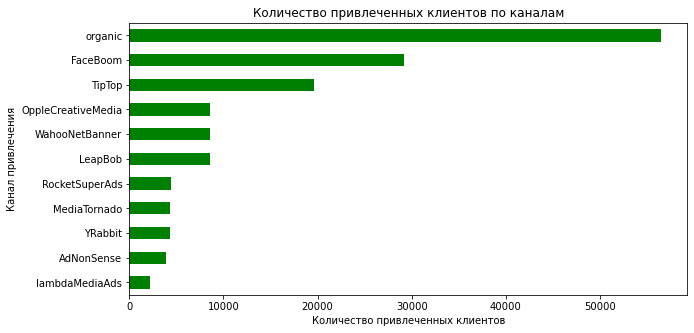

In [34]:
# визуализируем кол-во клиентов в разрезе каналов
profiles_by_channel = (
    profiles.groupby(['channel'])
    .agg({'user_id' : 'count', 'payer' : 'mean'})
    .sort_values('user_id', ascending=True)
)

profiles_by_channel.user_id.plot(kind='barh', color='g', figsize=(10,5))
plt.title('Количество привлеченных клиентов по каналам')
plt.xlabel('Количество привлеченных клиентов')
plt.ylabel('Канал привлечения')
plt.show();

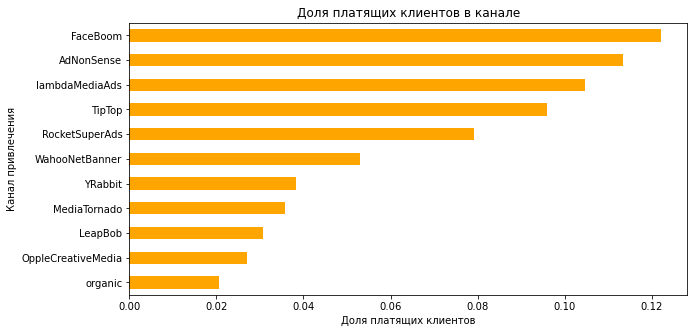

In [35]:
# визуализируем долю платящих клиентов в разрезе каналов
profiles_by_channel.payer.sort_values().plot(kind='barh', color='orange', figsize=(10,5))
plt.title('Доля платящих клиентов в канале')
plt.xlabel('Доля платящих клиентов')
plt.ylabel('Канал привлечения')
plt.show();

На канал organic приходится 37.6% всех пользователей, доля платящих в этом канале самая минимальная - 2%. Без учета этого канала, наибольшее кол-во клиентов пришло через канал FaceBoom - 29144, доля платящих в этом канале наибольшая  - 12.2%. Через канал TipTop привлечено 19561 клиентов, доля платящих - 9.6% (2-й результат по количеству привлеченных клиентов и  4-й результат по доле платящих). Высокую долю платящих показывают каналы AdNonSense (11.3%) и lambdaMediaAds (10.5%) - это 2-й и 3-й результаты по доле платящих соответственно, при этом количество привлеченных клиентов через эти каналы крайне низкое - всего 3880 и 2149 клиентов соответственно.

Выясним в каких регионах привлекаются пользователи через каналы AdNonSense и lambdaMediaAds.

Данные каналы имеют хорошую конверсию в платящих клиентов, плюс стоимость привлечения одного клиента в канале ниже среднего. Эти каналы выглядят перспективными.

In [36]:
# затраты на рекламу и кол-во привлеченных клиентов
perspective_channel = ['AdNonSense', 'lambdaMediaAds']
perspective_channels = profiles.query('channel == @perspective_channel')
perspective_channels = perspective_channels.groupby(['region', 'channel']).agg({'acquisition_cost' : 'sum', 'user_id' : 'nunique'}).sort_values('region', ascending=False)
perspective_channels

acquisition_cost  user_id
region  channel                                  
UK      AdNonSense           1305.650668     1295
        lambdaMediaAds        551.173800      758
Germany AdNonSense           1229.282545     1219
        lambdaMediaAds        471.287952      649
France  AdNonSense           1376.316788     1366
        lambdaMediaAds        535.138248      742

Привлечение в этих каналах происходит только в Европе.

## Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

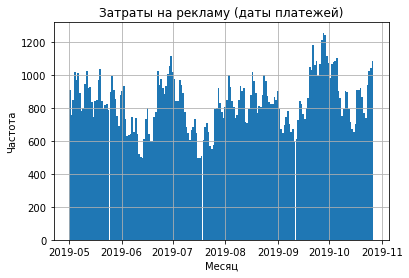

In [37]:
# построим гистограмму затрат на привлечение пользователей
profiles['dt'].hist(bins=(profiles['dt'].nunique()))
plt.title('Затраты на рекламу (даты платежей)')
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.show()

Затраты на рекламу имеют пики на начало каждого месяца. Пик затрат в июне достаточно узкий, начиная с июля затраты на рекламу увеличились (количество и периодичность платежей). Август характеризуется постоянными затратами на привлечение, в течение месяца видно 4 пика. Наибольшее количество платежей на рекламу зафиксировано в конце сентября - начале октября.

In [38]:
profiles.head(3)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000


In [39]:
# произведем расчет количества пользователей, в том числе платящих, а также рассчитаем ст-ть привлечения одного клиента
total_acquisition_cost = round(profiles['acquisition_cost'].sum(), 2)
uniq_users = profiles['user_id'].nunique()
print(f'Общая стоимость привлечения клиентов (затраты на привлечение): {total_acquisition_cost}')
print(f'Количество уникальных пользователей всего: {uniq_users}')

Общая стоимость привлечения клиентов (затраты на привлечение): 105497.3
Количество уникальных пользователей всего: 150008


**Для дальнейших расчетов не будем учитывать канал organic, так как это бесплатный канал привлечения.**

In [40]:
profiles = profiles.query('channel != "organic"') # сделаем срез
uniq_users = profiles['user_id'].nunique()
print(f'Количество уникальных платящих пользователей: {uniq_users}')
print(f'Стоимость привлечения одного клиента: {(total_acquisition_cost / uniq_users).round(2)}')

Количество уникальных платящих пользователей: 93569
Стоимость привлечения одного клиента: 1.13


In [41]:
# затраты на рекламу по каналам и кол-во привлеченных клиентов
acquisition_cost_grouped = profiles.groupby(['channel']).agg({'acquisition_cost' : 'sum', 'user_id' : 'nunique'}).sort_values('acquisition_cost', ascending=False)
# стоимость привлечения одного клиента
acquisition_cost_grouped['acq_cost_per_client'] = round(acquisition_cost_grouped['acquisition_cost'] / acquisition_cost_grouped['user_id'], 2)
acquisition_cost_grouped

,acquisition_cost,user_id,acq_cost_per_client
channel,,,
TipTop,54751.30,19561,2.80
FaceBoom,32445.60,29144,1.11
WahooNetBanner,5151.00,8553,0.60
AdNonSense,3911.25,3880,1.01
OppleCreativeMedia,2151.25,8605,0.25
RocketSuperAds,1833.00,4448,0.41
LeapBob,1797.60,8553,0.21
lambdaMediaAds,1557.60,2149,0.72
MediaTornado,954.48,4364,0.22


Самая дорогая стоимость привлечения одного клиента приходится на канал TipTop, следом идет FaceBoom. Дополнительно посмотрим в каких регионах действуют эти каналы привлечения.

In [42]:
expensive_channel = ['TipTop', 'FaceBoom']
expensive_channels = profiles.query('channel == @expensive_channel')
expensive_channels = expensive_channels.groupby(['region', 'channel']).agg({'acquisition_cost' : 'sum', 'user_id' : 'nunique'}).sort_values('region', ascending=False)
expensive_channels

acquisition_cost  user_id
region        channel                            
United States FaceBoom           32445.6    29144
              TipTop             54751.3    19561

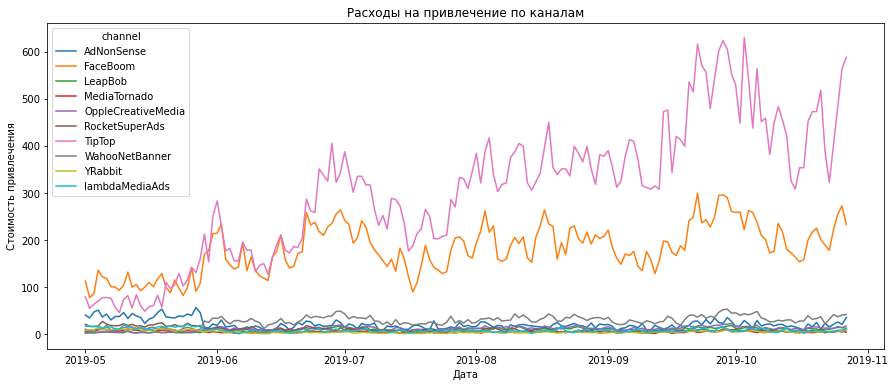

In [43]:
# визуализируем расходы по каналам за весь период исследования
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum').plot(figsize=(15,6))
plt.title('Расходы на привлечение по каналам')
plt.xlabel('Дата')
plt.ylabel('Стоимость привлечения')
plt.show()

График расходов на привлечения показывает, что основные расходы приходятся на каналы TipTop и FaceBoom (оба канала работают только на рынке США). Начиная с июля канал TipTop становится явным лидером по расходам на привлечение. Расходы на остальные каналы привлечения значительно ниже и в целом сопоставимы, немного выделяется канал WahooNetBanner, начиная с июня расходы на этот канал чуть выше остальных каналов этой "группы".

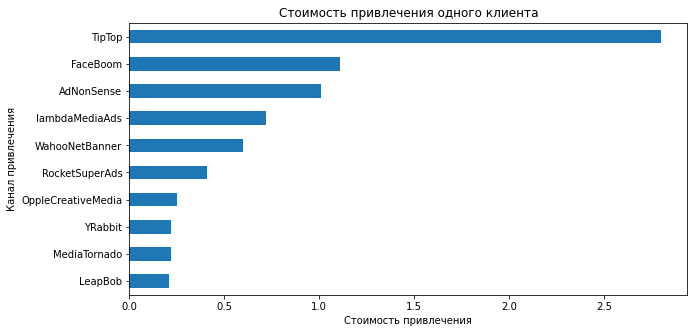

In [44]:
# визуализируем стоимость привлечения одного клиента в разрезе каналов
acquisition_cost_grouped.acq_cost_per_client.sort_values().plot(kind='barh', figsize=(10,5))
plt.title('Стоимость привлечения одного клиента')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Канал привлечения')
plt.show()

Стоимость привлечения одного клиента в канале TipTop самая высокая и отличается на порядок от стоимости привлечения по другим каналам. Так стоимость привлечения одного клиента в канале AdNonSense 1.01, против 2.8 в канале TipTop. Доля платящих клиентов в каналах сопоставима: 11.3% в AdNonSense и 12.2% в канале TipTop.

Стоимость привлечения в канале TipTop превышает в 2.5 раза среднюю стоимость привлечения одного клиента - 1.13. На втором месте по стоимости привлечения клиентов канал FaceBoom: стоимость привлечения одного клиента - 1.11.

In [45]:
# посмотрим на рекламные расходы по месяцам
acquisition_cost_grouped = profiles.groupby(['month']).agg({'acquisition_cost' : 'sum'}).sort_values('acquisition_cost', ascending=False)
acquisition_cost_grouped

,acquisition_cost
month,
2019-09-01,22441.340
2019-10-01,20882.415
2019-08-01,20657.870
2019-07-01,16447.060
2019-06-01,15090.045
2019-05-01,9978.570


Наибольшие расходы на рекламу были в сентябре, октябре и августе. Меньше всего было потрачено на рекламу в мае.

## Оценка окупаемости рекламы для привлечения пользователей

### Общая окупаемость рекламы

In [46]:
# установим момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

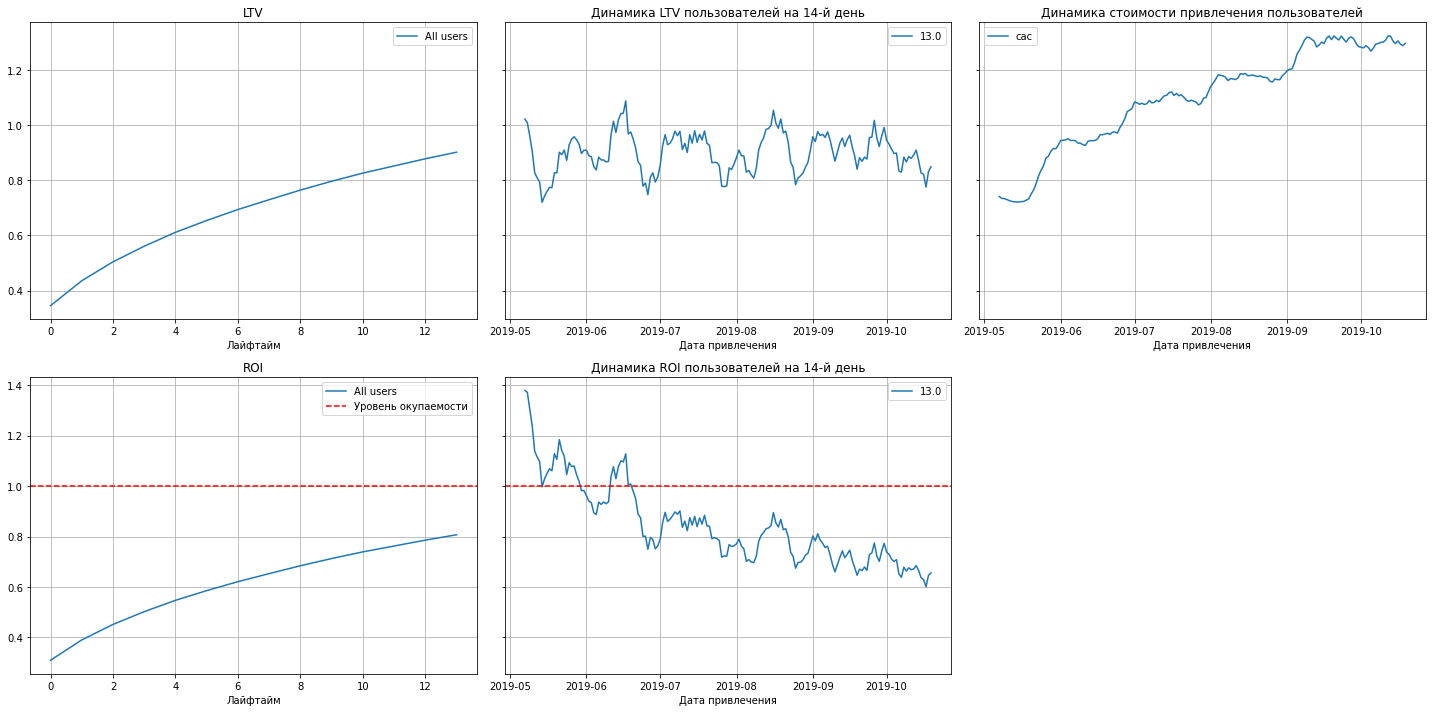

In [47]:
# рассчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По полученным графикам можно сделать следующие выводы:

Реклама не окупается: кривая окупаемости инвестиций ROI не превышает уровень окупаемости, и к концу двух недель находится чуть выше 80%.

ROI пользователей на 14-й день показывает отрицательную динамику, начиная с июня 2019 года, выйдя ненадолго в плюс в середине июня. Именно в этот моент зафиксировано снижение трат на привлечение клиентов в первую очередь в основных каналах - TipTop и FaceBoom.

CAC показывает постоянный рост, возможно именно значительное увеличение рекламного бюджета влияет на окупаемость инвестиций.

Динамика LTV показывает стабильный результат и находится в коридоре 80-100%.

### Окупаемость рекламы с разбивкой по устройствам

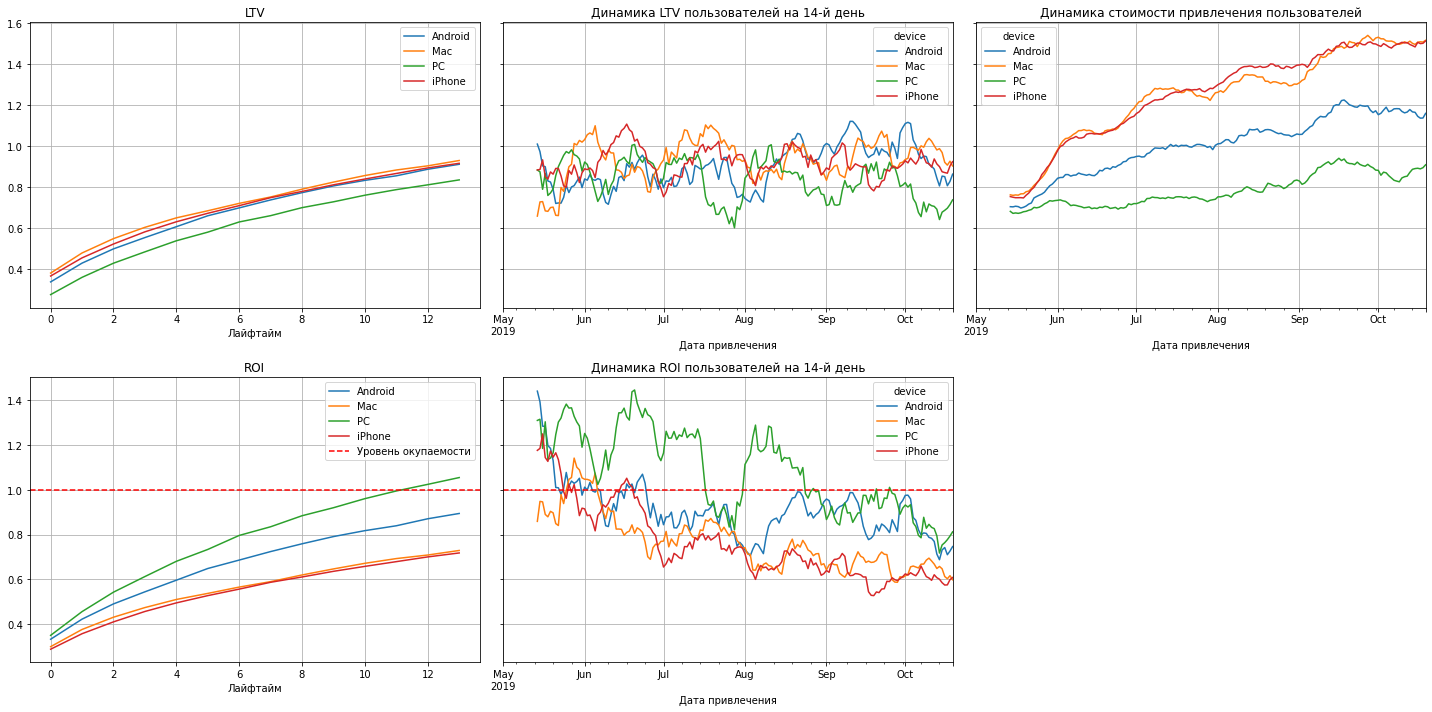

In [48]:
# рассмотрим окупаемость с разбивкой по устройствам пользователей

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Окупаемость инвестиций наблюдается только на PC. Кривая окупаемости пересекает линию окупаемости лишь на 11-й день.

Пользователи на других устройствах не окупаются: 
* Окупаемость пользователей на 14-й день, на Android около 90%, 
* Окупаемость пользователей на Mac и iPhone одинаковая: на уровне около 70%.

Наибольшие затраты приходятся на устройства Mac и iPhone, кривая затрат по PC показывает гораздо меньший рост и динамику.

Положительную динамику ROI пользователей показывают только пользователи на PC, в период с мая по сентябрь. Отрицательная динамика здесь зафиксирована в конце июля и в сентябре-октябре 2019 года. Пользователи на других устройствах показывают отрицательную окупаемость с июня.

### Окупаемость рекламы с разбивкой по странам

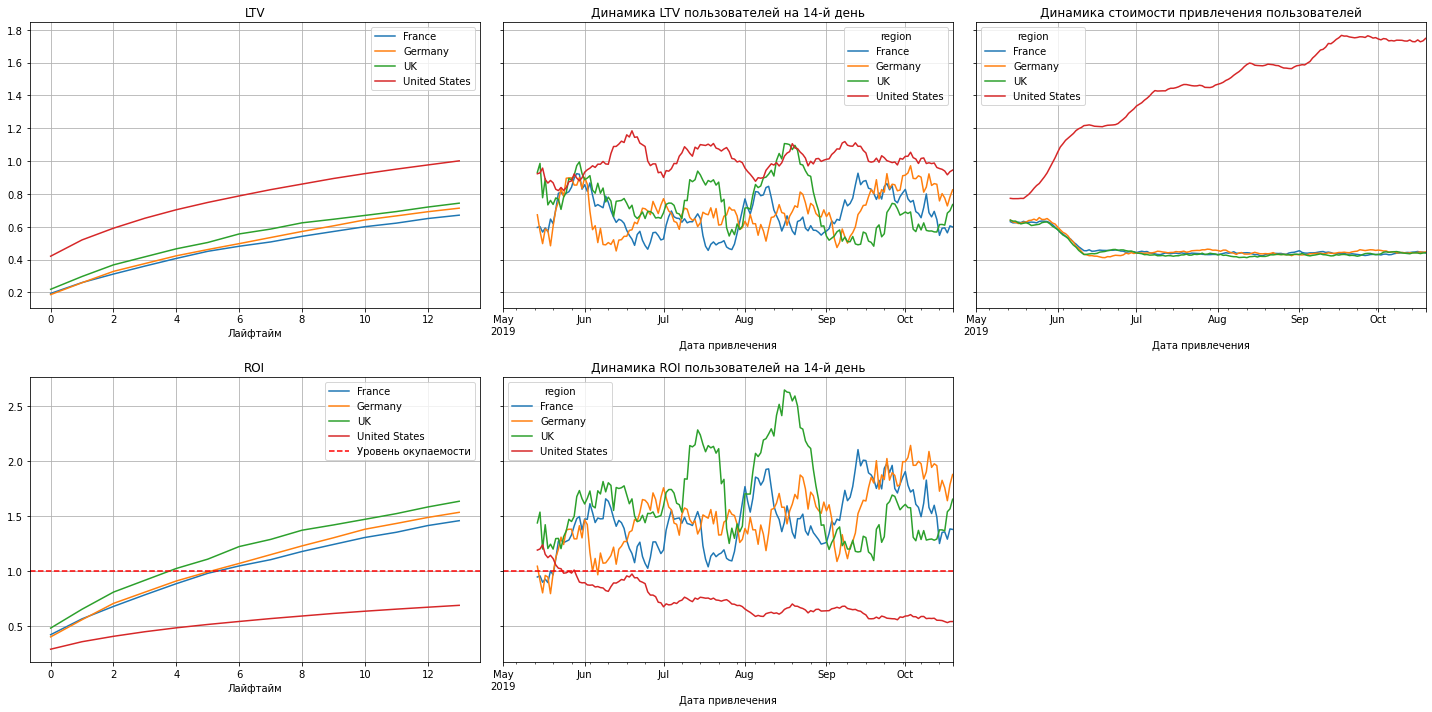

In [49]:
# посмотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Пользователи Франции, Германии и Великобритании показывают окупаемость на 6-й день, окупаемость пользователей из США находится на отметке 50% на этот день, и достигает отметку 70% к концу второй недели.

CAC пользователей значительно возросла с середины мая для пользователей США, в тоже время затраты на привлечение пользователей европейских стран зеркально снизилась. Начиная с середины июня затраты на привлечение пользователей Франции, Германии и Великобритании находятся на стабильном уровне, в то время как затраты на привлечение пользователей из США постоянно растут до середины сентября.

Динамика ROI на 14-й день для пользователей США постоянно отрицательная: кривая ROI постоянно снижается, стоимость привлечения пользователей США растет.

### Окупаемость рекламы с разбивкой по рекламным каналам

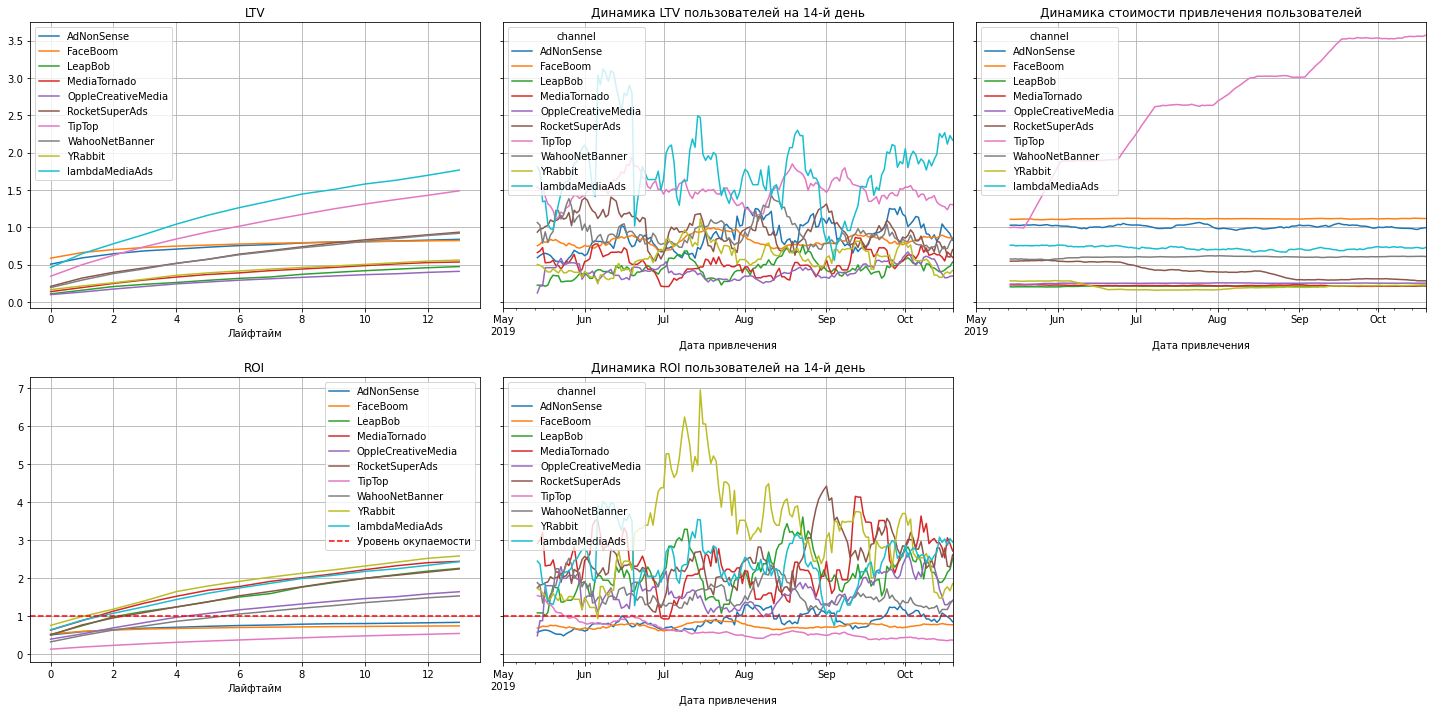

In [50]:
# посмотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Отрицательная окупаемость зафиксирована в следующих рекламных каналах: TipTop, FaceBoom, AdNonSence. Остальные каналы показывают окупаемость инвестиций.

Наилучшая окупаемость зафиксирована у канала YRabbit.

Стоимость привлечения в канале TipTop растет изо дня в день, в арифметической прогрессии.

## Конверсия и удержание клиентов

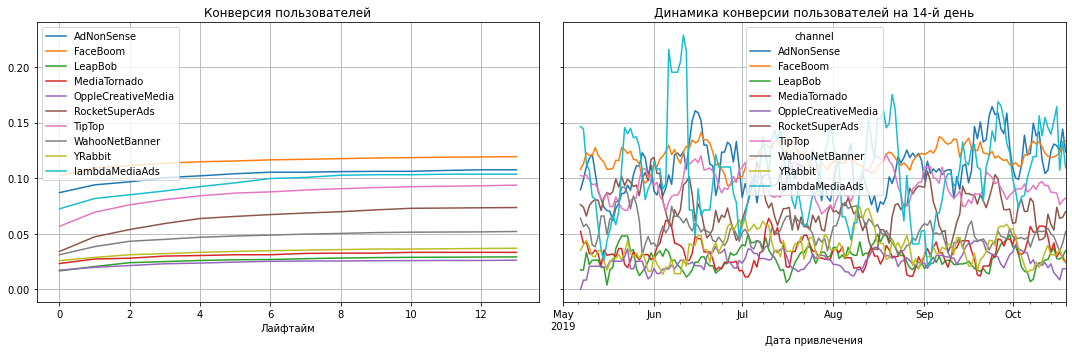

In [51]:
# посмотрим на конверсию с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

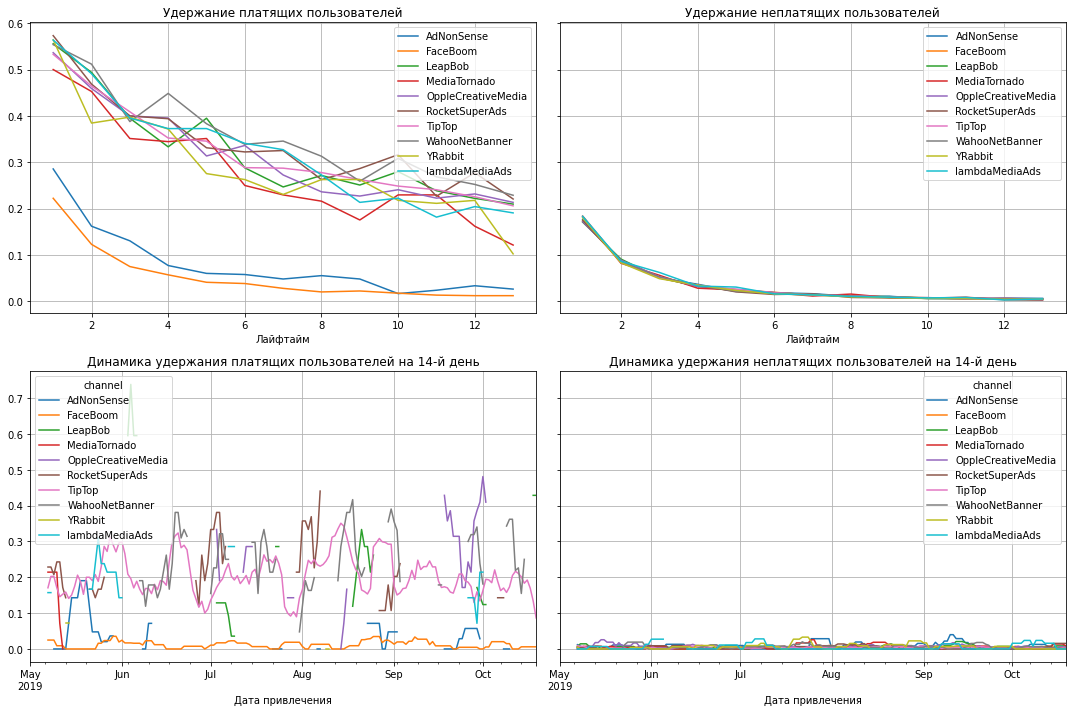

In [52]:
# смотрим удержание с разбивкой по каналам
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей ожидаемо выше неплатящих. Среди платящих пользователей самое низкое удержание в каналах AdNonSense и Faceboom.

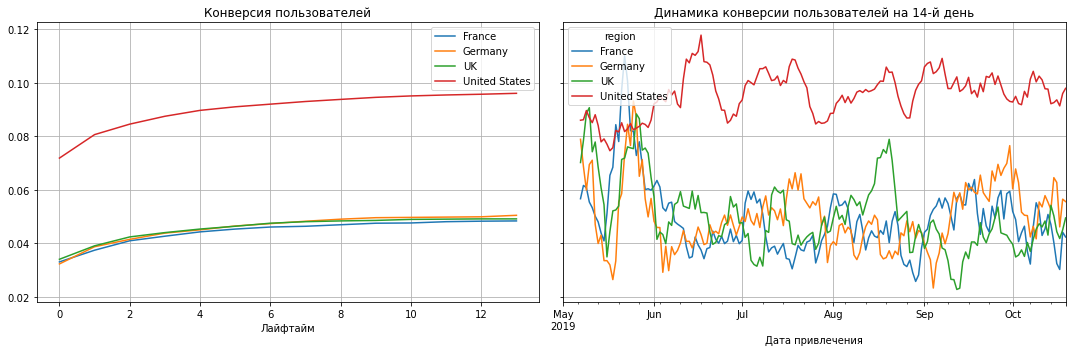

In [53]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

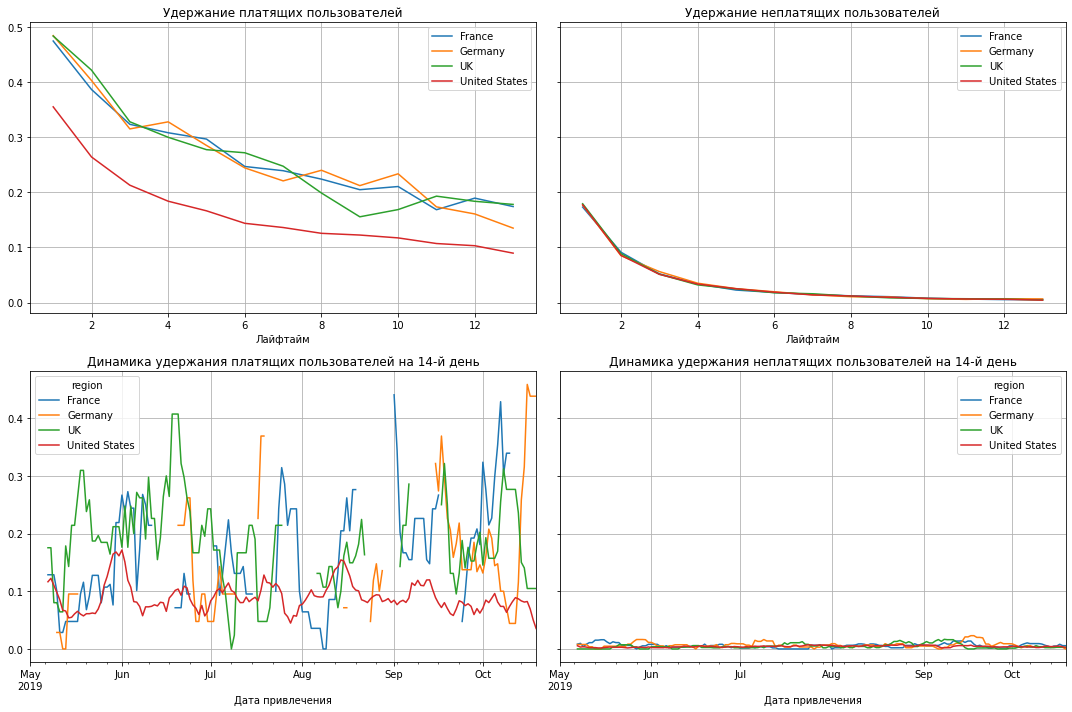

In [54]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

США показывают большую конверсию относительно других регионов, но кривая удержания клиентов ниже, чем в каком-либо другом регионе. Данный факт может говорить о том, что привлекаемые клиенты не являются целевыми и быстро "вымываются" из числа клиентов.

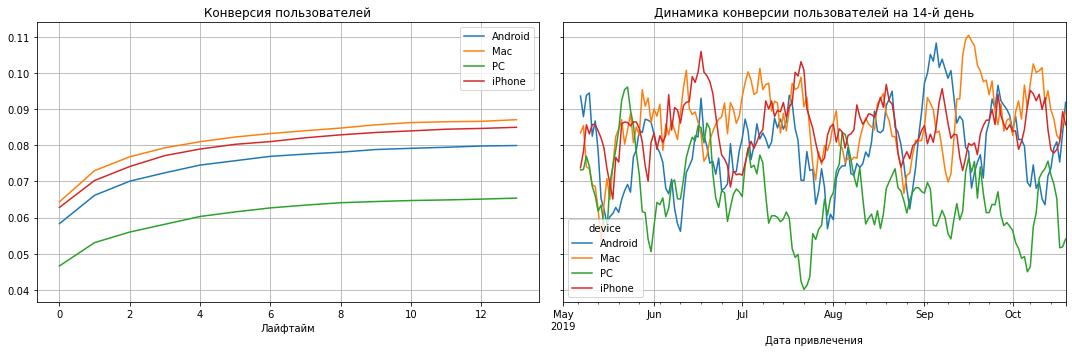

In [55]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

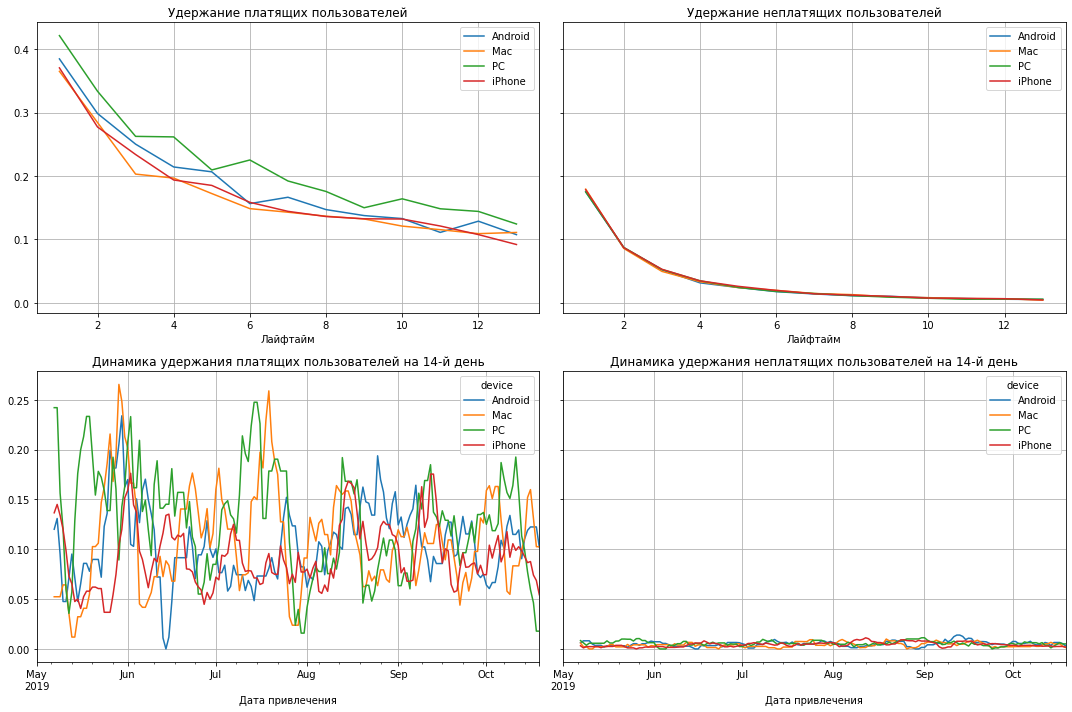

In [56]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Если смотреть на устройства пользователей, то удержание пользователей на iPhone и Mac хоть и ниже других устройств, но в целом сопоставимо с другими устройствами.

## Выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

В результате проведенных исследований можно сделать следующие выводы:

Рекламные вложения действительно не окупаются: кривая окупаемости инвестиций ROI к концу двух недель находится чуть выше 80%.

Кривая стоимости привлечения CAC растет на протяжении 5 месяцев.

Основные каналы по объемам платежей за привлечение клиентов это TipTop и Faceboom (свыше 82% рекламного бюджета приходится на эти каналы). Оба канала привлечения работают на рынке США. Стоимость привлечения одного клиента в этих каналах самая высокая относительно других каналов.

Рынок США занимает самую большую долю - около 66,7%, при этом показывает худшие показатели по удержанию клиентов относительно других регионов при изначально высокой конверсии.

С учетом вышесказанного можно сделать вывод, что основной причиной отсутствия окупаемости вложений на рекламу являются значительные расходы на привлечение пользователей в каналах TipTop и Faceboom: компания платит самую высокую цену за привлечение и получает "дорогих и нецелевых" клиентов с низким коэффициентом удержания, которые генерят убыток.

Окупаемость до значительного роста рекламных трат (период до середины июня 2019 года) имела положительный результат, что косвенно подтверждает сделанный вывод.

Высокую долю платящих клиентов показывают каналы AdNonSense (11.3%) и lambdaMediaAds (10.5%). Эти каналы привлечения работают на рынке Европы. Возможно стоит обратить внимание именно на эти компании, как имеющие определенные точки роста. Стоимость привлечения клиентов в этих каналах ниже среднего: 1.008 и 0.725 за клиента соответственно.

Таким образом, по итогам анализа можно выделить 3 рекомендации для отдела маркетинга:

- снижение и контроль рекламных расходов
- перераспределение рекламных расходов в сторону более дешевых каналов привлечения с хорошей конверсией в платящих клиентов
- поиск целевых клиентов на рынке Европы

В целях подтверждени озвученных выше выводов, можем еще раз рассчитать LTV и ROI, без учета привлечения клиентов и трат на рекламу в канале TipTop.

In [57]:
profiles_without_tiptop = profiles.query(('channel != "TipTop"'))

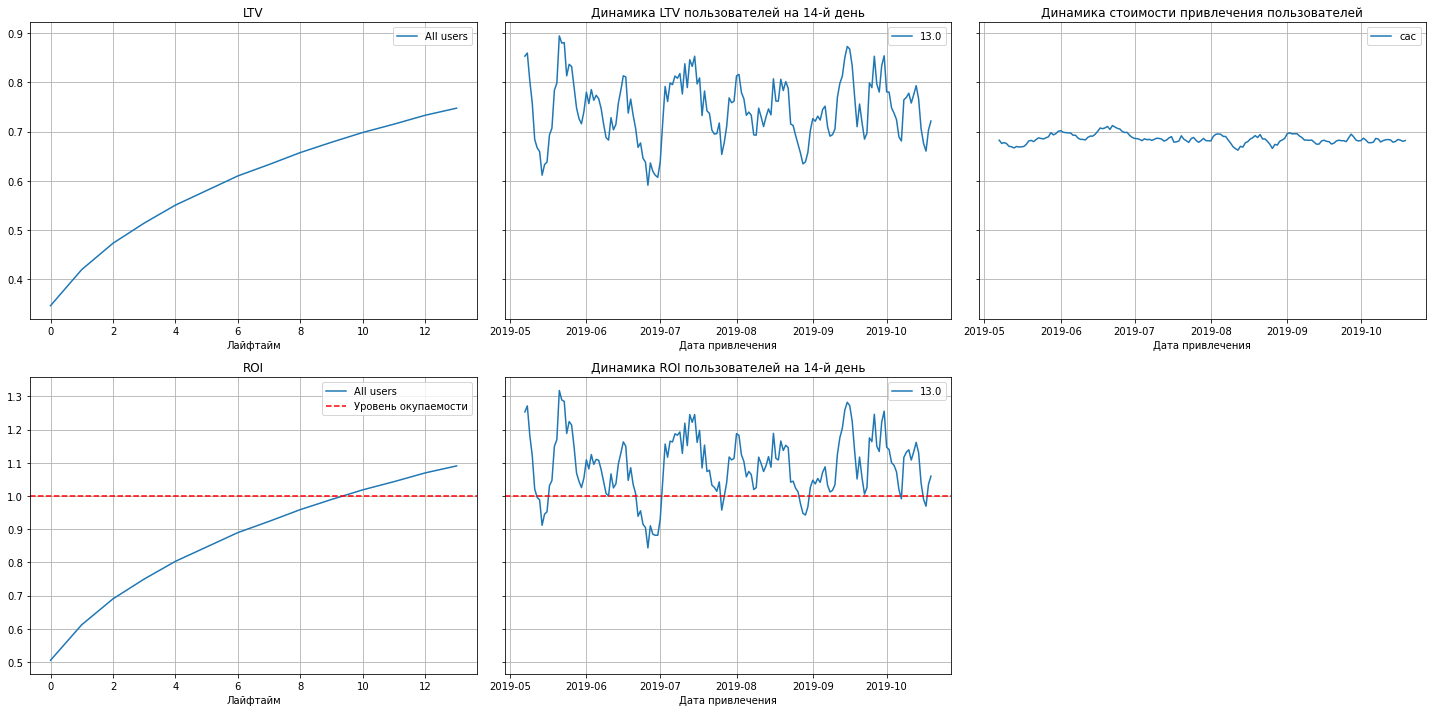

In [58]:
# рассчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_tiptop, orders, observation_date, horizon_days
)

# построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Окупаемость к концу 14-го дня составляет 110% против 80%, которые были ранее.**

Посмотрим на удержание клиентов без учета канала TipTop.

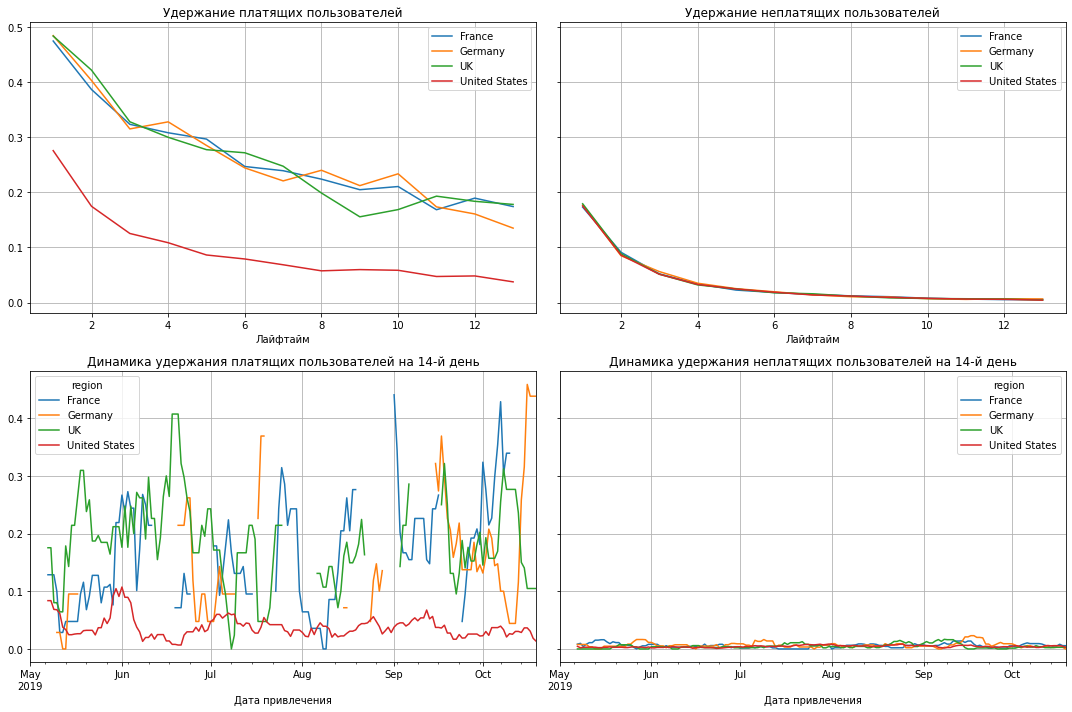

In [59]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_without_tiptop, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание клиентов в США по-прежнему ниже других регионов.

Исключим из расчета retention другую компанию на рынке США: FaceBoom. На привлечение пользователей через эту компанию также идут большие расходы.

In [60]:
# исключаем из расчетов 2 самых дорогих рекламных канала
profiles_without_expensive_channel = profiles.query(('channel != @expensive_channel'))

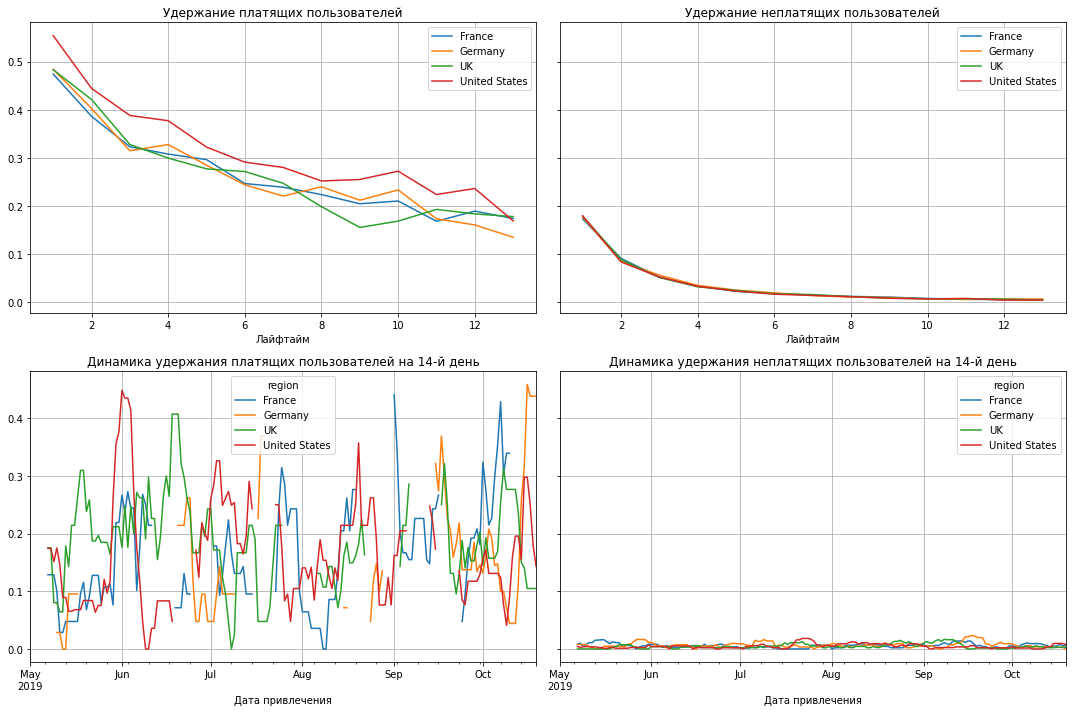

In [61]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_without_expensive_channel, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Без учета каналов FaceBoom и TipTop удержание в США показывает лучший результат относительно других стран. Таким образом, в результате проведенных исследований удалось локализовать 2 проблемы на рынке США: на плохой CAC влияет один канал - TipTop, а на низкий retention - другой канал - FaceBoom. На окупаемость может влиять, как одна метрика, так и другая.